<a href="https://colab.research.google.com/github/ZAsaee/Image_Segmentation-GastroIntestinal_Tract_Tumor_Detection/blob/main/Notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Packages**

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import imageio

%matplotlib inline

In [2]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# Open the folder
%cd /content/gdrive/My Drive/'Springboard_DS_program'/'CP3_Prj'/'Data'

/content/gdrive/My Drive/Springboard_DS_program/CP3_Prj/Data


In [4]:
!ls

filenames_df.csv  image_df.csv	labeled_data  raw_data	raw_data.zip


# **2. Load the Data**

In [5]:
# Read dataframes consisting of image information and segmentation
image_df = pd.read_csv('image_df.csv')
image_df.head(10)

,id,case,day,slice_id,size_x,size_y,spacing_x,spacing_y,class,segmentation
0,case101_day20_slice_0066,case101,day20,slice_0066,266,266,1.5,1.5,stomach,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,case101,day20,slice_0067,266,266,1.5,1.5,stomach,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,case101,day20,slice_0068,266,266,1.5,1.5,stomach,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,case101,day20,slice_0069,266,266,1.5,1.5,stomach,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,case101,day20,slice_0070,266,266,1.5,1.5,stomach,28918 9 29182 14 29446 18 29711 21 29976 23 30...
5,case101_day20_slice_0071,case101,day20,slice_0071,266,266,1.5,1.5,stomach,28117 12 28382 16 28647 18 28912 21 29177 24 2...
6,case101_day20_slice_0072,case101,day20,slice_0072,266,266,1.5,1.5,stomach,27053 9 27317 14 27582 16 27847 19 28112 22 28...
7,case101_day20_slice_0073,case101,day20,slice_0073,266,266,1.5,1.5,stomach,26786 9 27050 14 27314 18 27579 21 27844 23 28...
8,case101_day20_slice_0074,case101,day20,slice_0074,266,266,1.5,1.5,large_bowel,31080 6 31345 8 31610 10 31876 10 32142 10 324...
9,case101_day20_slice_0074,case101,day20,slice_0074,266,266,1.5,1.5,stomach,26517 10 26781 16 27046 19 27311 22 27577 23 2...


In [6]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33913 entries, 0 to 33912
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            33913 non-null  object 
 1   case          33913 non-null  object 
 2   day           33913 non-null  object 
 3   slice_id      33913 non-null  object 
 4   size_x        33913 non-null  int64  
 5   size_y        33913 non-null  int64  
 6   spacing_x     33913 non-null  float64
 7   spacing_y     33913 non-null  float64
 8   class         33913 non-null  object 
 9   segmentation  33913 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 2.6+ MB


In [7]:
# Load and save the image files names
path = ''
image_dir = os.path.join('labeled_data')

In [9]:
image_list = os.listdir(image_dir)

In [10]:
# Check the number of entries to match with the number of files
len(image_list)

38496

In [11]:
# Create a list of image files that there exist in the dataframe and labeled_data folder
image_files = list(image_df.id)
image_files = [image_dir+ '/' + i + '.png' for i in image_files]

In [12]:
image_files[:3]

['labeled_data/case101_day20_slice_0066.png',
 'labeled_data/case101_day20_slice_0067.png',
 'labeled_data/case101_day20_slice_0068.png']

Check out some of the images from the dataset.

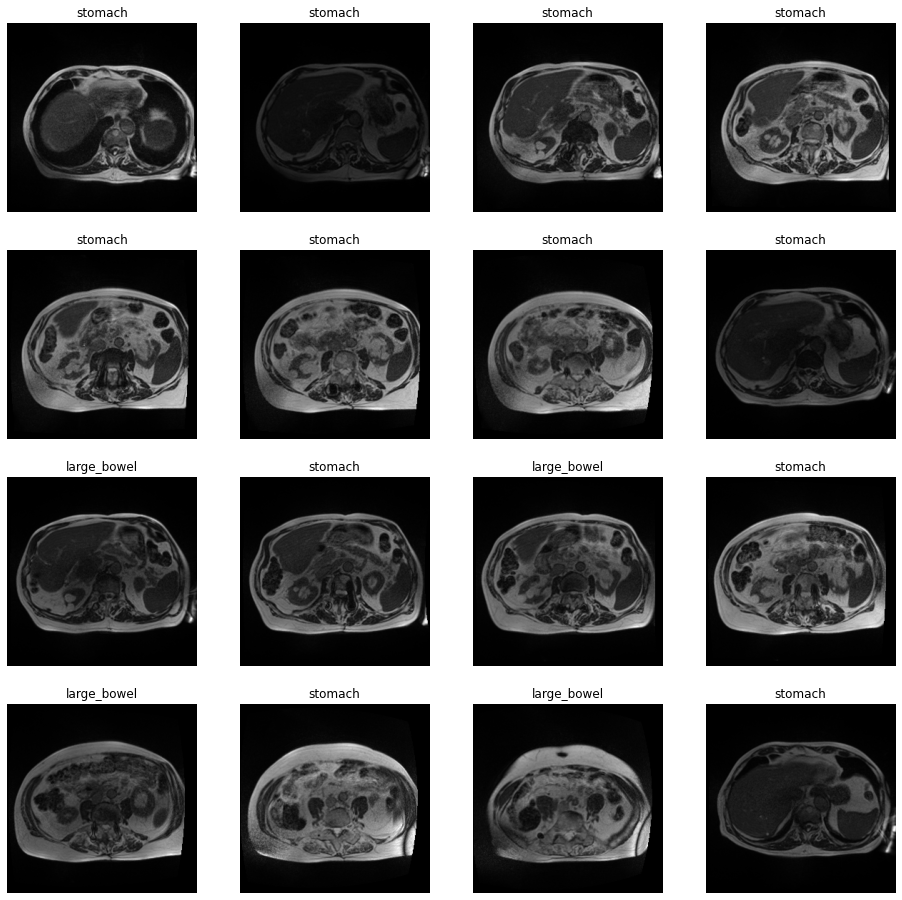

In [13]:
# Parameters for the graph: output images in 4x4 configuration
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(nrows*4, ncols*4)

for i in range(nrows * ncols):
  img = imageio.imread(image_files[i*15])
  title = image_df.iloc[i]['class']
  
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off')
  plt.title(title)
  plt.imshow(img, cmap='gray')

plt.show()

# **3. Convert RLE-encoding to mask image**

The annotation of images are provided by the RLE-encoding technique. I define a function to convert RLE to masked images. 

In [ ]:
# Define a function to convert RLE format to mask

def rle2mask(mask_rle:str, label = 1, input_shape = (1, 1)):
  # mask_rle: Run-Length Encoding as a string
  # label: output 1 for mask, 0 for background
  # input_shape: image size to return an array with this size
  
  # Split the starts pixels and length and store in two arrays
  rle_lst = list(map(int, mask_rle.split()))
  starts, lengths = [np.array(x) for x in (rle_lst[::2], rle_lst[1::2])]
  
  # deduct 1 from starts to match with the array index
  starts -= 1
  ends = starts + lengths
  
  # Create a zero 2_d array with the image size
  mask_img = np.zeros(input_shape[0] * input_shape[1], dtype=np.uint8)

  # Replace the mask pixels with 1
  for w, h in zip(starts, ends):
    mask_img[w:h] = label
  
  return mask_img.reshape(input_shape)
  # return starts, lengths, mask_img

Let's check some of the images and their mask from the dataset.

In [ ]:
mask_rle = image_df.segmentation
input_shape_rle = list(zip(image_df.size_x, image_df.size_y))

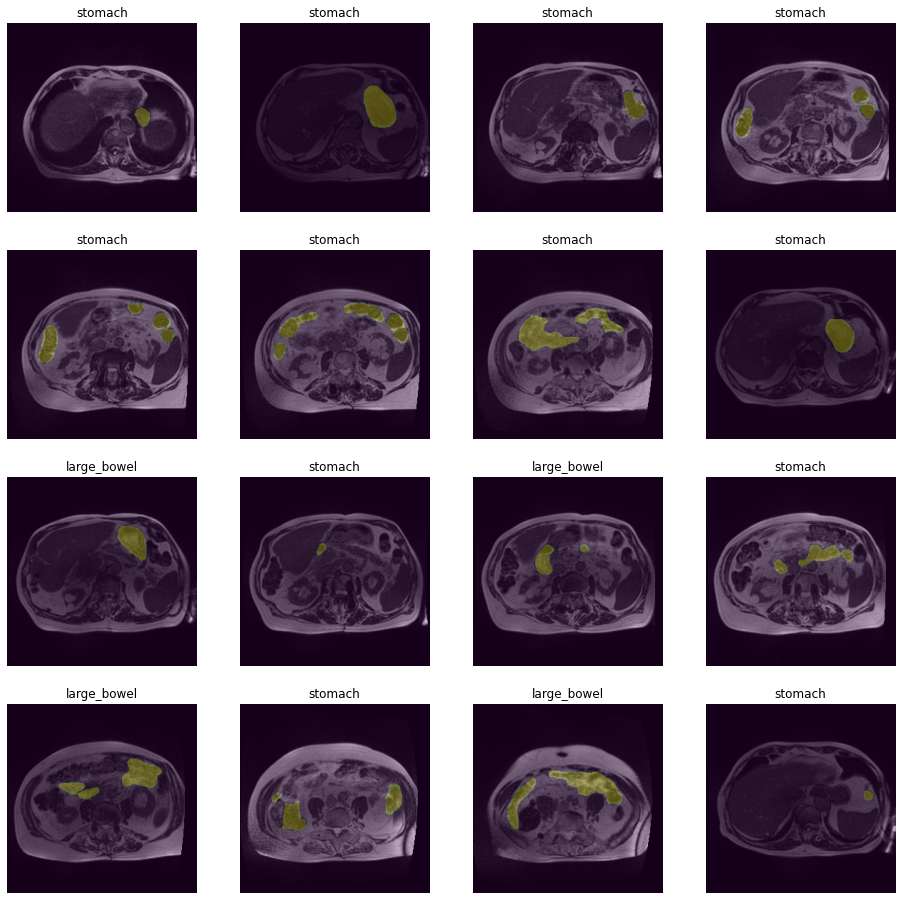

In [ ]:
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(nrows*4, ncols*4)

for i in range(nrows * ncols):
  n = i * 15
  img = imageio.imread(image_files[n])
  rle = mask_rle[n]
  shape = input_shape_rle[n]
  title = image_df.iloc[i]['class']
    
  mask = rle2mask(rle, label=1, input_shape=shape)

  sp = plt.subplot(nrows, ncols, i+1)
  plt.imshow(img, cmap='gray')
  plt.imshow(mask, alpha=0.3, cmap='gray')
  sp.axis('off')
  plt.title(title)

plt.show()

